## Imports

In [3]:
!pip install -q tensorflow

In [4]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
from sklearn.model_selection import train_test_split
import tempfile
import matplotlib.pyplot as plt

## Distribution Strategy For GPU Usage

In [5]:
# Detect TPU, return appropriate distribution strategy

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU', tpu.master)
except ValueError:
  tpu = None


if tpu:
  tf.config.experimental.connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
else:
  strategy = tf.distribute.get_strategy()

print('REPLICAS: ', strategy.num_replicas_in_sync)

REPLICAS:  1


## Download the flower dataset

The flower dataset was downloaded from `Tensorflow Datasets` using the link below:

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

The file folder was extracted using `7-Zip`. `7-Zip` is a free, open-source file archiver used to compress and extract files.

flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips

## Load Dataset from Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp /content/drive/MyDrive/datasets/flower_photos.zip /content/

In [8]:
!unzip -q /content/flower_photos.zip

Check for the total number of images in the dataset.

Expected: 3670

In [9]:
from pathlib import Path

data_dir = '/content/flower_photos'  #/content/flower_photos
data_path = Path(data_dir)

image_count = len(list(data_path.glob('*/*.jpg')))
print(image_count)

3670


Print Dataset sub-directory

In [10]:
for subdir in data_path.iterdir():
  if subdir.is_dir():
    print(subdir.resolve())

/content/flower_photos/roses
/content/flower_photos/dandelion
/content/flower_photos/daisy
/content/flower_photos/sunflowers
/content/flower_photos/tulips


In [11]:
# Dataset directory
"""
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips
"""



'\nflowers_photos/\n  daisy/\n  dandelion/\n  roses/\n  sunflowers/\n  tulips\n'

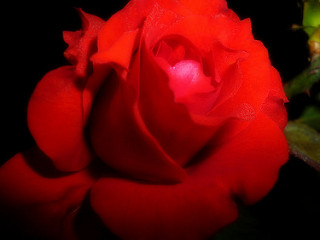

In [12]:
import PIL
import PIL.Image

# Roses
roses = list(data_path.glob('roses/*'))
PIL.Image.open(str(roses[0]))

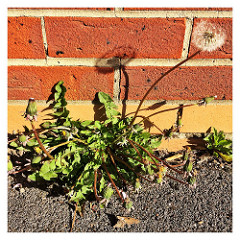

In [13]:
# Dandelion
dandelion = list(data_path.glob('dandelion/*'))
PIL.Image.open(str(dandelion[2]))

##NOTE:

## TFRecords are faster than reading individual JPEGs

For this reason, we will convert our `JPEG Images to TFRecords`. And use it on Tensorflow TPU

## Convert JPEG Images to TFRecords

In [14]:
import tensorflow as tf
import os

# Configuration
DATA_DIR = "/content/flower_photos"
CLASS_NAMES = ['daisy', 'roses', 'dandelion', 'tulips', 'sunflowers']
OUTPUT_DIR = "/content/tfrecords"
os.makedirs(OUTPUT_DIR, exist_ok=True)

image_paths = []
labels = []

for class_idx, class_name in enumerate(CLASS_NAMES):
  class_dir = os.path.join(DATA_DIR, class_name)
  for img_file in os.listdir(class_dir):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
      image_paths.append(os.path.join(class_dir, img_file))
      labels.append(class_idx)

In [15]:
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))

Number of image paths: 3670
Number of labels: 3670


In [16]:

def write_tfrecord(image_paths, labels, output_file):
  with tf.io.TFRecordWriter(output_file) as writer:
    for img_path, label in zip(image_paths, labels):
      img_raw = open(img_path, 'rb').read()  # raw-bytes

      # Create a TFExample
      example = tf.train.Example(features=tf.train.Features(feature={
          'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
          'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
      }))
      writer.write(example.SerializeToString())

#image_dir = data_dir
#image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
#labels = [0, 1, 1, 0, ...]   # # Replace with actual labels




In [17]:
# Split image_paths and labels into train=70%, validation=20%, & test=10%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.33, random_state=42
)

# Write train, valid and test TFRecords
write_tfrecord(train_paths, train_labels, "tfrecords/train.tfrec")
write_tfrecord(val_paths, val_labels, "tfrecords/val.tfrec")
write_tfrecord(test_paths, test_labels, "tfrecords/test.tfrec")

## Sharding: Split into multiple .tfrec files

In [18]:
"""
import numpy as np

shards = 10
for i in range(shards):
  shard_paths = np.array_split(image_paths, shards)[i]
  shard_labels = np.array_split(labels, shards)[i]
  write_tfrecord(shard_paths, shard_labels, f"/tfrecords/train_{i:02d}.tfrec")
"""

'\nimport numpy as np\n\nshards = 10\nfor i in range(shards):\n  shard_paths = np.array_split(image_paths, shards)[i]\n  shard_labels = np.array_split(labels, shards)[i]\n  write_tfrecord(shard_paths, shard_labels, f"/tfrecords/train_{i:02d}.tfrec")\n'

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
IMAGE_RESIZE = [256, 256]

## Load the Splits

In [20]:
import tensorflow as tf

# For single file paths (no wildcard needed)
TRAINING_FILE = "/content/tfrecords/train.tfrec"  # Direct path
VALID_FILE = "/content/tfrecords/val.tfrec"
TEST_FILE = "/content/tfrecords/test.tfrec"

# Verify files exist
def check_file(path):
    if tf.io.gfile.exists(path):
        print(f"Found: {path}")
        return [path]  # Return as list to match multi-file interface
    else:
        print(f"Missing: {path}")
        return []

TRAINING_FILENAMES = check_file(TRAINING_FILE)
VALID_FILENAMES = check_file(VALID_FILE)
TEST_FILENAMES = check_file(TEST_FILE)

print("\nResults:")
print(f"Train: {TRAINING_FILENAMES} ({len(TRAINING_FILENAMES)} files)")
print(f"Val: {VALID_FILENAMES} ({len(VALID_FILENAMES)} files)")
print(f"Test: {TEST_FILENAMES} ({len(TEST_FILENAMES)} files)")

Found: /content/tfrecords/train.tfrec
Found: /content/tfrecords/val.tfrec
Found: /content/tfrecords/test.tfrec

Results:
Train: ['/content/tfrecords/train.tfrec'] (1 files)
Val: ['/content/tfrecords/val.tfrec'] (1 files)
Test: ['/content/tfrecords/test.tfrec'] (1 files)


In [21]:
""""

import os

# Check what's actually in your /tfrecords/ directory
print("Contents of /tfrecords/:")
print(os.listdir("/tfrecords/"))

# Or for more details:
for root, dirs, files in os.walk("/tfrecords"):
    print(f"Directory: {root}")
    print(f"Files: {files}")

"""

'"\n\nimport os\n\n# Check what\'s actually in your /tfrecords/ directory\nprint("Contents of /tfrecords/:")\nprint(os.listdir("/tfrecords/"))\n\n# Or for more details:\nfor root, dirs, files in os.walk("/tfrecords"):\n    print(f"Directory: {root}")\n    print(f"Files: {files}")\n\n'

In [22]:
TRAINING_FILENAMES = tf.io.gfile.glob("/content/tfrecords/train.tfrec")
VALID_FILENAMES = tf.io.gfile.glob("/content/tfrecords/val.tfrec")
TEST_FILENAMES = tf.io.gfile.glob("/content/tfrecords/test.tfrec")

print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 1
Validation TFRecord Files: 1
Test TFRecord Files: 1


## Decode the Image

In [23]:
def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.cast(image, tf.float32) / 255
  #image = tf.reshape(image, [*IMAGE_SIZE, 3])
  image = tf.image.resize(image, IMAGE_SIZE)
  return image


## Read TFRecord

In [24]:

def read_tfrecord(example, labeled):
  tfrecord_format = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "label": tf.io.FixedLenFeature([], tf.int64)
  } if labeled else {
      "image" : tf.io.FixedLenFeature([], tf.string),
      "image_name" : tf.io.FixedLenFeature([], tf.string)
  }
  example = tf.io.parse_single_example(example, tfrecord_format)
  image = decode_image(example['image'])

  if labeled:
    return image, tf.cast(example['label'], tf.int32)
  return image, example['image_name']

In [25]:
def load_dataset(filenames, labeled=True, ordered=False):
  ignore_order = tf.data.Options()
  if not ordered:
    ignore_order.experimental_deterministic = False
  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
  dataset = dataset.with_options(ignore_order)
  dataset = dataset.map(
      partial(read_tfrecord, labeled=labeled),
      num_parallel_calls=AUTOTUNE
  )
  return dataset


## Data Augmentation

Use 'data_augmentation' instead of 'augmentation_pipeline'

In [26]:
def augmentation_pipeline(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.resize(image, IMAGE_RESIZE)
  return image, label


## Loading Method

In [27]:
def get_training_dataset():
  dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
  dataset = dataset.map(
      augmentation_pipeline,
      num_parallel_calls=AUTOTUNE)
  #dataset = dataset.repeat()
  dataset = dataset.shuffle(1024)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTOTUNE)
  return dataset

In [28]:
def get_validation_dataset(ordered=False):
  dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.cache()
  dataset = dataset.prefetch(AUTOTUNE)
  return dataset

In [29]:
def get_test_dataset(ordered=False):
  dataset = load_dataset(TEST_FILENAMES, labeled=True, ordered=ordered)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTOTUNE)
  return dataset

## Count Images in files

In [30]:
import tensorflow as tf

def count_tfrecord_examples(filename):
  return sum(1 for _ in tf.data.TFRecordDataset(filename))

num_of_train_images = count_tfrecord_examples('/content/tfrecords/train.tfrec')
num_of_validation_images = count_tfrecord_examples('/content/tfrecords/val.tfrec')
num_of_test_images = count_tfrecord_examples('/content/tfrecords/test.tfrec')

print("Train Images:", num_of_train_images)
print("Validation Images:", num_of_validation_images)
print("Test Images:", num_of_test_images)

Train Images: 2569
Validation Images: 737
Test Images: 364


## Build Model

In [31]:
# Learning Rate Auto-Adjustment

def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 **(epoch/s)
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## Data Exploration

In [32]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
  print(image.numpy().shape, label.numpy().shape)
print("Training data label examples", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
  print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, label in get_test_dataset().take(3):
  print(image.numpy().shape, label.numpy().shape)
print("Test Data IDs:", label.numpy())

Training data shapes:
(16, 256, 256, 3) (16,)
(16, 256, 256, 3) (16,)
(16, 256, 256, 3) (16,)
Training data label examples [4 3 1 3 1 2 0 3 2 3 4 2 4 0 2 2]
Validation data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Validation data label examples: [2 2 2 3 2 1 2 2 3 1 1 1 1 3 3 1]
Test data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Test Data IDs: [1 0 0 3 4 0 1 2 0 3 1 3 3 1 2 1]


## QWERTY

In [33]:
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf

def display_batch(images, label=None, predictions=None, class_names=None, figsize=13.0):
  "Display a batch of images with optional labels/predictions in a grid"

  # Convert to numpy if needed
  if tf.is_tensor(images):
    images = images.numpy()
  if label is not None and tf.is_tensor(label):
    label = label.numpy()
  if label is not None and label.dtype == object:
    label = None

  n = len(images)
  rows = int(math.sqrt(n))
  cols = math.ceil(n/rows)

  fig, axes = plt.subplots(rows, cols, figsize=(figsize, figsize* rows / cols))
  axes = axes.flatten()

  for i, (ax, img) in enumerate(zip(axes, images)):
    ax.imshow(img)
    ax.axis('off')

    if label is not None or predictions is not None:
      title_parts = []
      correct = True

      if predictions is not None and class_names:
        pred = predictions[i]
        title_parts.append(class_names[pred])

        if label is not None:
          true_label = label[i]
          correct = (pred == true_label)
          if not correct:
            title_parts.append(f"(True: {class_names[true_label]})")

      elif label is not None and class_names:
        title_parts.append(class_names[labels[i]])

      title = " ".join(title_parts)
      color = 'red' if (predictions is not None and not correct) else 'black'
      ax.set_title(title, color=color, pad=10)

    plt.tight_layout()
    plt.show()

## Load our Dataset for EDA

In [34]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [35]:
def display_batch(images, labels=None, predictions=None, class_names=None, figsize=(12, 12)):
    if tf.is_tensor(images):
        images = images.numpy()
    if labels is not None and tf.is_tensor(labels):
        labels = labels.numpy()
    if predictions is not None and tf.is_tensor(predictions):
        predictions = predictions.numpy()

    batch_size = images.shape[0]
    plt.figure(figsize=figsize)
    for i in range(batch_size):
        plt.subplot(4, 5, i+1)  # 4x5 grid for 20 images
        image = images[i]
        if image.max() <= 1.0:
            image = (image * 255).astype("uint8")  # Scale back to 0–255
        else:
            image = image.astype("uint8")
        plt.imshow(image)
        title = ""
        if labels is not None:
            label_idx = labels[i]
            title += f"Label: {class_names[label_idx] if class_names else label_idx}"
        if predictions is not None:
            pred_idx = predictions[i]
            title += f"\nPred: {class_names[pred_idx] if class_names else pred_idx}"
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


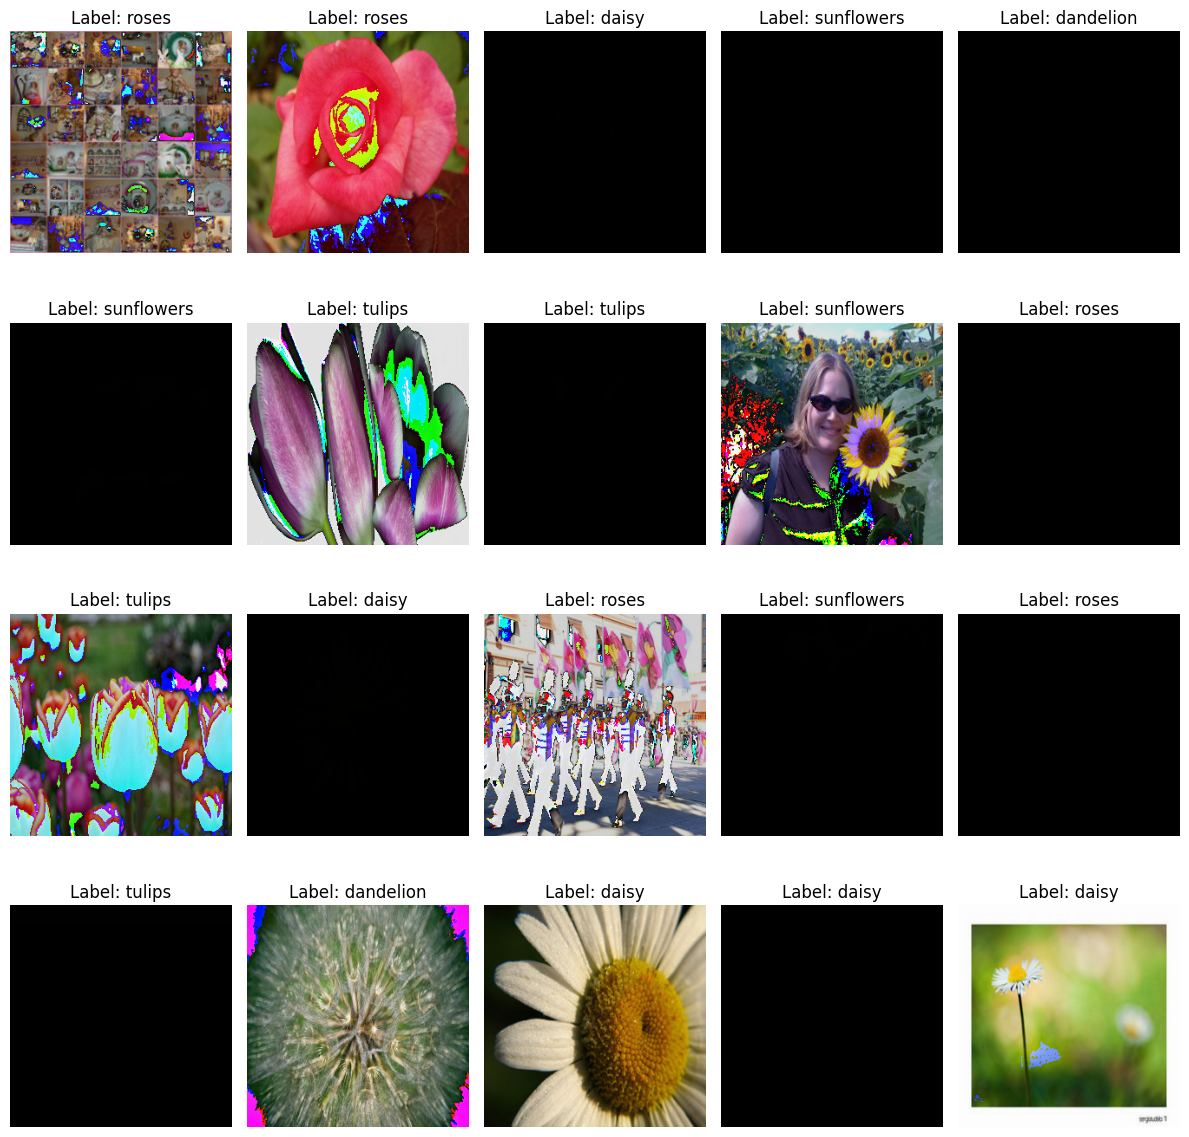

In [36]:
images, labels = next(iter(train_batch))
display_batch(images, labels, class_names=CLASS_NAMES)


In [37]:
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20)
valid_batch = iter(validation_dataset)

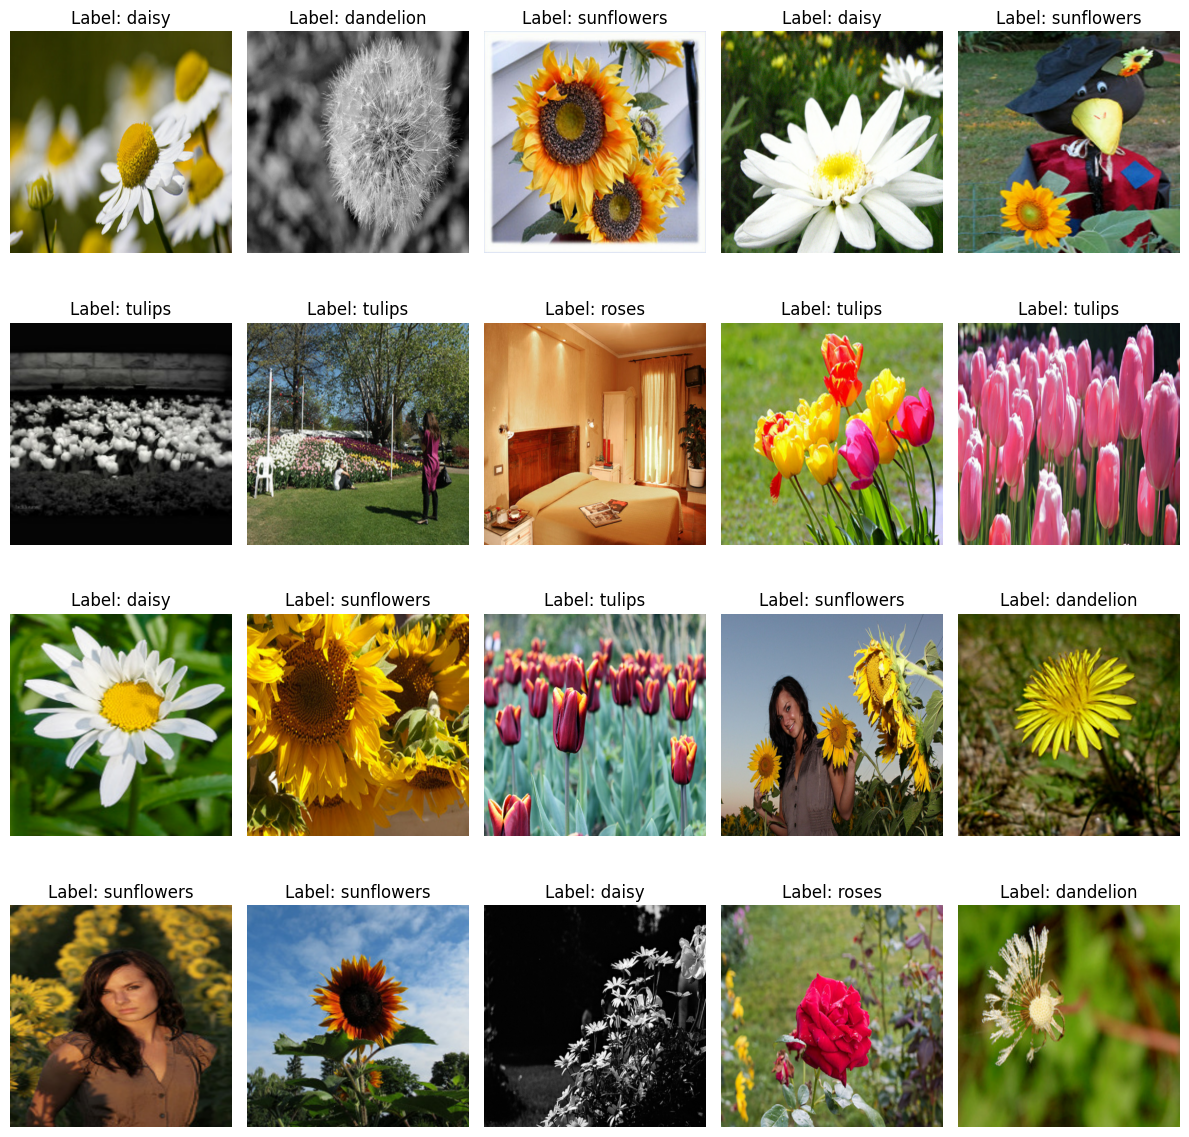

In [38]:
images, labels = next(iter(valid_batch))
display_batch(images, labels, class_names=CLASS_NAMES)

In [39]:
testing_dataset = get_test_dataset()
testing_dataset = testing_dataset.unbatch().batch(20)
test_batch = iter(testing_dataset)

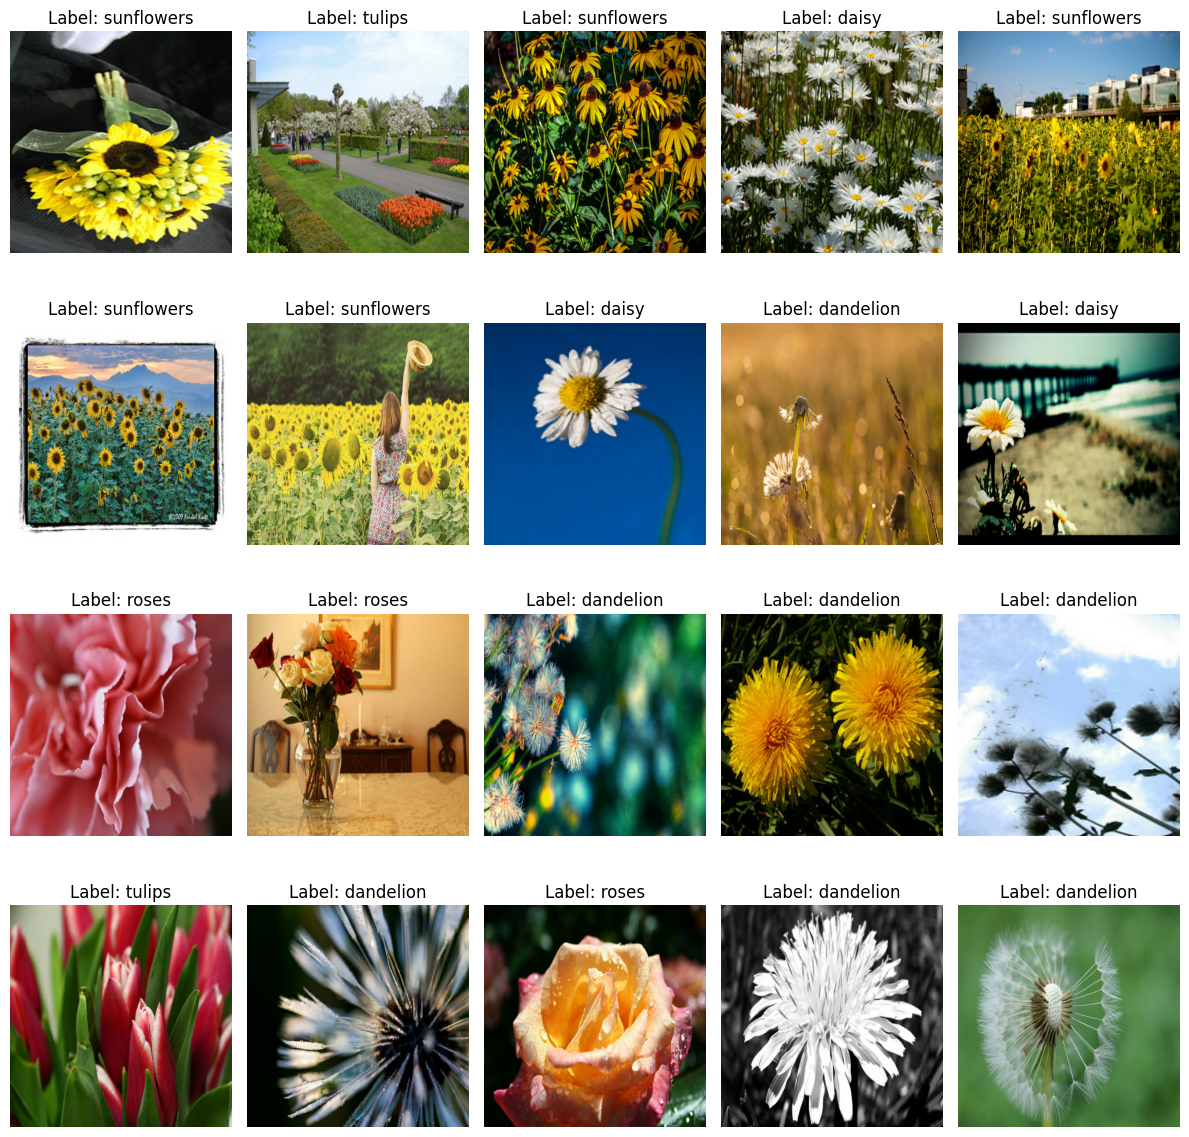

In [40]:
images, labels = next(iter(valid_batch))
display_batch(images, labels, class_names=CLASS_NAMES)

## Building Model

In [41]:
from tensorflow import keras

lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.9
)

In [42]:
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 25



with strategy.scope():
  img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape=[*IMAGE_SIZE, 3])
  base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
  base_model.trainable = False

  model = tf.keras.Sequential([
      tf.keras.layers.BatchNormalization(),
      img_adjust_layer,
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(len(CLASSES), activation='softmax')
  ])

  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy']
  )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Train Dataset

In [43]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [ ]:
steps_per_epoch = num_of_train_images // BATCH_SIZE
valid_steps = num_of_validation_images // BATCH_SIZE

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset,
    validation_steps=valid_steps
)

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.8327 - sparse_categorical_accuracy: 0.1287

# XXXXXXXXXXXXXXXXXXXXXXXXX